In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
data_dir = 'D:\DL\Food image Classification\Food/'

In [3]:
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [4]:
train_data = datagen.flow_from_directory(data_dir, target_size = (128,128), batch_size = 15, class_mode = 'categorical',
                                        subset = 'training')

val_data = datagen.flow_from_directory(data_dir, target_size = (128,128), batch_size = 15, class_mode = 'categorical',
                                        subset = 'validation')

Found 9600 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.


In [5]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(12, activation="softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        8

In [6]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
history = model.fit(train_data, epochs = 10, verbose = 1,validation_data=val_data)

Epoch 1/10
640/640 [==============================] - 437s 675ms/step - loss: 2.3849 - accuracy: 0.1407 - val_loss: 2.3230 - val_accuracy: 0.1813
Epoch 2/10
640/640 [==============================] - 462s 722ms/step - loss: 2.2550 - accuracy: 0.2123 - val_loss: 2.2157 - val_accuracy: 0.2317
Epoch 3/10
640/640 [==============================] - 438s 684ms/step - loss: 2.0816 - accuracy: 0.2860 - val_loss: 2.0727 - val_accuracy: 0.2904
Epoch 4/10
640/640 [==============================] - 485s 758ms/step - loss: 1.8945 - accuracy: 0.3555 - val_loss: 2.0216 - val_accuracy: 0.3342
Epoch 5/10
640/640 [==============================] - 265s 413ms/step - loss: 1.6462 - accuracy: 0.4452 - val_loss: 1.9876 - val_accuracy: 0.3683
Epoch 6/10
640/640 [==============================] - 218s 340ms/step - loss: 1.3411 - accuracy: 0.5487 - val_loss: 2.0699 - val_accuracy: 0.3417
Epoch 7/10
640/640 [==============================] - 211s 330ms/step - loss: 0.9619 - accuracy: 0.6770 - val_loss: 2.4183 -

In [7]:
model.evaluate(val_data)
model.save("D:\DL\Food image Classification\models\CNN.h5")

160/160 [==============================] - 12s 74ms/step - loss: 4.6297 - accuracy: 0.3229


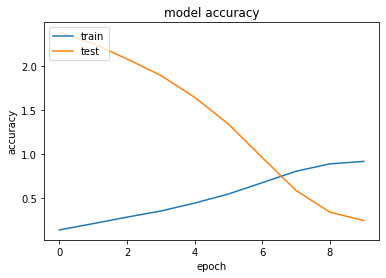

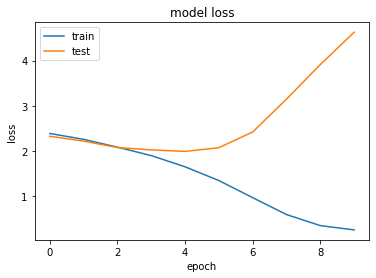

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
ReLU = tf.keras.layers.ReLU()

In [10]:
def fire_module(x,s1,e1,e3):
    s1x = Conv2D(s1,kernel_size = 1, padding = 'same')(x)
    s1x = ReLU()(s1x)
    e1x = Conv2D(e1,kernel_size = 1, padding = 'same')(s1x)
    e3x = Conv2D(e3,kernel_size = 3, padding = 'same')(s1x)
    x = concatenate([e1x,e3x])
    x = ReLU()(x)
    return x

In [11]:
def SqueezeNet(input_shape=(64,64,3), nclasses=12):
    input = Input(input_shape)
    x = Conv2D(96,kernel_size=(7,7),strides=(2,2),padding='same')(input)
    x = MaxPool2D(pool_size=(3,3), strides = (2,2))(x)
    x = fire_module(x, s1 = 16, e1 = 64, e3 = 64) #2
    x = fire_module(x, s1 = 16, e1 = 64, e3 = 64) #3
    x = fire_module(x, s1 = 32, e1 = 128, e3 = 128) #4
    x = MaxPool2D(pool_size=(3,3), strides = (2,2))(x)
    x = fire_module(x, s1 = 32, e1 = 128, e3 = 128) #5
    x = fire_module(x, s1 = 48, e1 = 192, e3 = 192) #6
    x = fire_module(x, s1 = 48, e1 = 192, e3 = 192) #7
    x = fire_module(x, s1 = 64, e1 = 256, e3 = 256) #8
    x = MaxPool2D(pool_size=(3,3), strides = (2,2))(x)
    x = fire_module(x, s1 = 64, e1 = 256, e3 = 256) #9
    x = Dropout(0.5)(x)
    x = Conv2D(nclasses,kernel_size = 1)(x)
    output = AvgPool2D(pool_size=(13,13))(x)
    model = Model(input, output)
    return model
model1=model
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        8

In [12]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
history1 = model1.fit(train_data, epochs = 10, verbose = 1,validation_data=val_data)

Epoch 1/10
640/640 [==============================] - 211s 326ms/step - loss: 0.1875 - accuracy: 0.9415 - val_loss: 5.9100 - val_accuracy: 0.3100
Epoch 2/10
640/640 [==============================] - 210s 328ms/step - loss: 0.1372 - accuracy: 0.9592 - val_loss: 5.7771 - val_accuracy: 0.3246
Epoch 3/10
640/640 [==============================] - 212s 331ms/step - loss: 0.1248 - accuracy: 0.9632 - val_loss: 6.0881 - val_accuracy: 0.3075
Epoch 4/10
640/640 [==============================] - 921s 1s/step - loss: 0.1182 - accuracy: 0.9640 - val_loss: 6.2682 - val_accuracy: 0.3196
Epoch 5/10
640/640 [==============================] - 272s 425ms/step - loss: 0.1080 - accuracy: 0.9664 - val_loss: 6.9772 - val_accuracy: 0.3067
Epoch 6/10
640/640 [==============================] - 201s 315ms/step - loss: 0.1050 - accuracy: 0.9680 - val_loss: 7.2324 - val_accuracy: 0.3208
Epoch 7/10
640/640 [==============================] - 208s 325ms/step - loss: 0.1080 - accuracy: 0.9696 - val_loss: 6.8941 - va

In [13]:
model1.evaluate(val_data)
model1.save("D:\DL\Food image Classification\models\SqueezeNet.h5")

160/160 [==============================] - 12s 76ms/step - loss: 8.0841 - accuracy: 0.3000


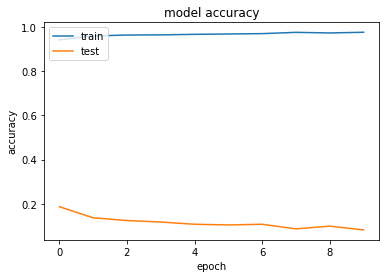

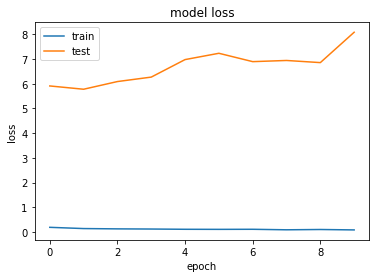

In [14]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
base_model2 = tf.keras.applications.VGG16(input_shape=(64, 64, 3), include_top=False,
                          weights='imagenet')
model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(12, activation='sigmoid'))
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 14,748,556
Trainable params: 14,748,428
Non-trainable params: 128
__________________________________________

In [6]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
history2 = model2.fit(train_data, epochs = 10, verbose = 1,validation_data=val_data)

Epoch 1/10
640/640 [==============================] - 2713s 4s/step - loss: 2.4882 - accuracy: 0.1201 - val_loss: 2.8718 - val_accuracy: 0.1375
Epoch 2/10
640/640 [==============================] - 2697s 4s/step - loss: 2.3918 - accuracy: 0.1403 - val_loss: 2.5610 - val_accuracy: 0.1275
Epoch 3/10
640/640 [==============================] - 2473s 4s/step - loss: 2.3226 - accuracy: 0.1641 - val_loss: 2.7311 - val_accuracy: 0.1517
Epoch 4/10
640/640 [==============================] - 2343s 4s/step - loss: 2.2837 - accuracy: 0.1794 - val_loss: 2.3108 - val_accuracy: 0.1942
Epoch 5/10
640/640 [==============================] - 2727s 4s/step - loss: 2.2610 - accuracy: 0.1853 - val_loss: 2.6860 - val_accuracy: 0.1462
Epoch 6/10
640/640 [==============================] - 2536s 4s/step - loss: 2.2354 - accuracy: 0.1918 - val_loss: 2.2526 - val_accuracy: 0.1958
Epoch 7/10
640/640 [==============================] - 2244s 4s/step - loss: 2.2312 - accuracy: 0.1920 - val_loss: 2.4044 - val_accuracy:

In [7]:
model2.evaluate(val_data)

160/160 [==============================] - 126s 787ms/step - loss: 8189762.5000 - accuracy: 0.1625


[8189762.5, 0.16249999403953552]

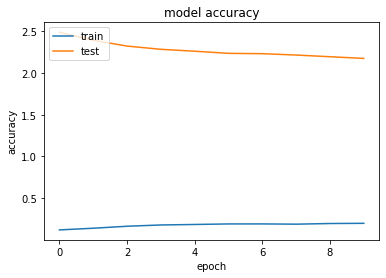

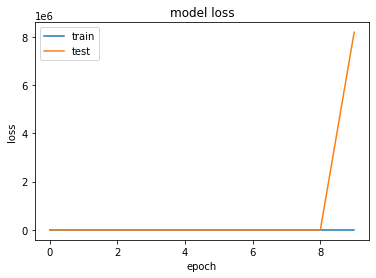

In [8]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
model2.save("D:\DL\Food image Classification\models\VGG16.h5")

In [10]:
Accuracy = []

for i in [history, history1, history2]:
    x = i.history.get('accuracy')[-1]
    Accuracy.append(x)

Accuracy

NameError: name 'history' is not defined

In [11]:
from skimage import io
from keras.preprocessing import image

img = image.load_img(r'D:\DL\Food image Classification\Food\apple_pie\134.jpg', grayscale=False, target_size=(128,128))
show_img=image.load_img(r'D:\DL\Food image Classification\Food\apple_pie\134.jpg', grayscale=False, target_size=(200, 200))
Food = ['Calcium deficiency','Complete nutrition', 'Iron Deficiency', 'Magnesium Deficiencies', 'Nitrogen Deficiency', 'Potassium Deficiency']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Food[ind])

NameError: name 'model' is not defined